In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn.preprocessing import OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder
#import scikit-learn 

import lightgbm as lgb
import sklearn
#from lightgbm import LGBMCLassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.model_selection import ParameterGrid, KFold

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve


In [2]:
os.getcwd()

'C:\\Users\\rida.amjad\\Python Preparation\\ML Project\\ClassificationPipeline'

In [3]:
#Fetch config file
with open('config/config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
categorical_feats = config['Categorical_features']
numeric_feats = config['numeric_features']
util_feats = config['util_features']
target_metric = config['Target_metric']

features = categorical_feats + numeric_feats + util_feats + target_metric
# remove None from my features
all_features = [x for x in features if str(x) != 'None']

In [5]:
all_features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst',
 'id',
 'diagnosis']

In [6]:
config['Csv_path']

'breast-cancer.csv'

In [7]:
def fetch_csv(config):
    if config['Csv_path'] == "":
        print("No csv path given")
    else:
        x = pd.read_csv(config['Csv_path'], usecols = all_features)
        return x

In [8]:
x = fetch_csv(config)

In [9]:
x.head(2)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [10]:
def data_summary(df,config):
    """
     Prints a summary of the given DataFrame, including the total number of rows and the number of missing values.

    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.
    config (dict): A configuration dictionary (currently not used within the function but included for potential future use or compatibility).

    Returns:
    None: This function prints the summary directly and does not return any value.
    """
    print(f"The total number of rows of this data is:{df.shape[0]}")
    if df.isna().sum().reset_index()[0].sum() == 0:
        print("There are no missing values in the provided dataframe")
    else:
        print(f"There is a total of {df.isna().sum()} missing values in the dataset")

In [11]:
data_summary(x,config)

The total number of rows of this data is:569
There are no missing values in the provided dataframe


In [12]:
def target_metric_check_convert(df,config):

    """
    Checks if the target metric column in the DataFrame is binary and converts it to binary values (0 and 1) if necessary.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the target metric column.
    config (dict): A dictionary containing configuration details. It must have a key 'Target_metric' that specifies the target column.

    Returns:
    pd.Series: A Series containing the converted binary target metric values.
    """
    target_metric = config['Target_metric']
    print("Checking whether target metric is binary")
   
    if df[target_metric].nunique().iloc[0] != 2:
        raise ValueError("Target column must have exactly two unique values.")
    else:    
        print("Target metric is binary.")

    # Check if unique values are already 0 and 1
    unique_values = df[target_metric].iloc[:,0].unique()
    if set(unique_values) != {0, 1}:
        print("Converting target metric to binary values 0 and 1.")
        
        # Map original values to 0 and 1
        value_map = {unique_values[0]: 0, unique_values[1]: 1}
        y = df[target_metric].iloc[:,0]
        y = y.map(value_map)
    
    return y
#        unique_values = df[target_metric].unique()
#        value_to_binary = {unique_values[0]: 0, unique_values[1]: 1}
#        df[target_metric] = df[target_metric].map(value_to_binary)  
#        return df
    

In [13]:
y = target_metric_check_convert(x,config)

Checking whether target metric is binary
Target metric is binary.
Converting target metric to binary values 0 and 1.


In [14]:
y

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: diagnosis, Length: 569, dtype: int64

In [15]:
class MissingFeaturesError(Exception):
    """Custom exception for missing feature sets."""
    pass

In [16]:
# impute missing values 
def impute_numeric_feature(df, config):
    if numeric_feats is None:
        print("No numeric features to impute") 
        return df

    # Check if numeric features exist in the DataFrame
    missing_cols = [col for col in numeric_feats if col not in df.columns]
    if missing_cols:
        raise ValueError(f"These features are not present in the DataFrame: {missing_cols}")

    #Convert the numeric columns to as numeric first
    df[numeric_feats] = df[numeric_feats].apply(pd.to_numeric, errors = 'coerce')
    
    # Now define the imputation value based on what's provided
    if config['numeric_imputation'] == 'mean':
        impute_values = df[numeric_feats].mean()
    elif isinstance(imputation_method, (int, float)):
        impute_values = imputation_method
    else:
        raise ValueError(f"Invalid imputation method specified: {imputation_method}")    
    
    # Impute the values
    df[numeric_feats] = df[numeric_feats].fillna(impute_values)
        
    return df[numeric_feats]
    

In [17]:
r = impute_numeric_feature(x,config)

In [18]:
# impute missing values
def impute_categorical_feature(df, config):
    
    if not categorical_feats or all(feat is None for feat in categorical_feats):
        print("No categorical features to impute.")
        return pd.DataFrame()

    # Check if categorical features exist in the DataFrame
    missing_cols = [col for col in categorical_feats if col not in df.columns]
    if missing_cols:
        raise ValueError(f"These features are not present in the DataFrame: {missing_cols}")

    impute_values = 'unknown'
    df[categorical_feats] = df[categorical_feats].fillna(impute_values)   
    return df[categorical_feats]

In [19]:
categorical_feats

[None]

In [20]:
s = impute_categorical_feature(x,config)

No categorical features to impute.


In [21]:
s

""


In [22]:
df_new = pd.concat([r,s], axis = 'columns')

In [23]:
df_new

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [24]:
# Encoding Function
def encode_features(df, config):
    """
    it transforms features so it can be ingested by a tree model

    params:
    df:dataframe returned from last function (numeric imputation one)
    config: config.yaml file
    """
    if not categorical_feats or all(feat is None for feat in categorical_feats):
        print("No categorical features to encode.")
        return df
    else:
    # Check names of all categorical columns that have unique value count greater than 50
        cat_cols_1 = []
        cat_cols_2 = []
        for i in categorical_feats:
            if len(df[i].unique()) >= 50:
                cat_cols_1.append(i)
            else:
                cat_cols_2.append(i)
    
        # Initialize empty DataFrames for transformed columns
        df_new_1 = pd.DataFrame(index=df.index)
        df_new_2 = pd.DataFrame(index=df.index)
    
        # Apply ordinal encoding on cat_cols_2
        if cat_cols_2:
            ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1111)
            ordinal_encoder.fit(df[cat_cols_2])
            df_new_1 = pd.DataFrame(ordinal_encoder.transform(df[cat_cols_2]), columns=cat_cols_2, index=df.index)
        
        # Apply rare label encoding on cat_cols_1
        if cat_cols_1:
            rare_encoder = RareLabelEncoder(tol=0.05, max_n_categories=50, variables=cat_cols_1, ignore_format=True)
            rare_encoder.fit(df[cat_cols_1])
            df_new_2 = pd.DataFrame(rare_encoder.transform(df[cat_cols_1]), columns=cat_cols_1, index=df.index)
    
        # Concatenate the transformed data
        if not df_new_1.empty and not df_new_2.empty:
            df_new = pd.concat([df_new_1, df_new_2], axis='columns')
        elif not df_new_1.empty:
            df_new = df_new_1
        elif not df_new_2.empty:
            df_new = df_new_2
        else:
            df_new = pd.DataFrame(index=df.index)  # No categorical features to encode
    
        # Add any other columns from the original DataFrame that are not in categorical_feats
        other_columns = df.drop(columns=categorical_feats)
        df_final = pd.concat([df_new, other_columns], axis='columns')
    
        print(df_final.head())
        return df_final

In [25]:
df_final = encode_features(df_new, config)

No categorical features to encode.


In [26]:
df_final

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [27]:
config['train_test_split']

0.8

In [28]:
from sklearn.model_selection import train_test_split as sk_train_test_split
def train_test_split(X, y, config):
    if config['train_test_split'] is None:
        raise ValueError("The 'train_test_split' configuration is missing.")

    if not isinstance(config['train_test_split'], float):
        raise ValueError("The 'train_test_split' configuration is not a float.")

    if not (0 < config['train_test_split'] < 1):
        raise ValueError("The 'train_test_split' configuration must be greater than 0 and less than 1.")

    test_size = 1 - config['train_test_split']
    X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size = test_size, random_state = 1)

    return X_train, X_test, y_train, y_test
    

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_final, y, config)

In [30]:
with open('params.yaml') as f:
    params = yaml.load(f, Loader = yaml.FullLoader)

params

{'n_estimators': [100, 250, 500, 850, 1000],
 'max_bins': [10, 25, 50],
 'min_child_samples': [25, 50, 100],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
 'colsample_bytree': [0.7, 1.0],
 'subsample': [0.7, 1.0]}

In [31]:
## Train Test Split
def run_lightgbm(X,y, config):
    """
    Trains a LightGBM model using the provided feature matrix and target variable. It performs a randomized search
    for hyperparameter tuning and fits the final model with the best parameters.

    Parameters:
    X (pd.DataFrame): The feature matrix.
    y (pd.Series): The target variable.
    config (dict): A dictionary containing configuration details. The dictionary should include the list of categorical features
                   as `categorical_feats` and model parameters as `params`.

    Returns:
    dict: A dictionary containing the randomized search object (`search`) and the trained model (`model`).

    """
    
    if not categorical_feats or all(feat is None for feat in categorical_feats):
        categorical_cols = []
    else:
        categorical_cols = categorical_feats
    params['metric'] = ['auc']
    neg_pos_ratio = np.sum(y==0)/np.sum(y==1)
    params['scale_pos_weight'] = [1, neg_pos_ratio, neg_pos_ratio*2, neg_pos_ratio*4]
    print(categorical_cols)

#    y = pd.Series(y)
    n_rows = X.shape[0]
    
    model = lgb.LGBMClassifier()
# Add this if you want to be able to run GridSearchCV 
#    if n_rows < 50000:
#        print("Dataset has less than 50000 rows, Using GridSearchCV.")
#        search = GridSearchCV(model, params, cv = 5,scoring = 'roc_auc',
#                              n_jobs = -1)
#    else:
#        n_iter = 50
#        search = RandomizedSearchCV(model, params, cv = 5, n_jobs = -1, random_state =1 )

    n_iter = 50
    search = RandomizedSearchCV(model, params, cv = 5, n_jobs = -1, random_state =1 )
    search.fit(X,y, categorical_feature = categorical_cols )
    print("The highest AUC Score achieved" %  search.best_score_)
    final_params = search.best_estimator_.get_params()
    #Fit model with final parameters

    model = lgb.LGBMClassifier(**final_params)
    model.fit(X,y,categorical_feature = categorical_cols)
    return {'search': search,
           'model': model}
    

In [32]:
model = run_lightgbm(X_train,y_train, config)

[]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 285, number of negative: 170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626374 -> initscore=0.516691
[LightGBM] [Info] Start training from score 0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [33]:
model['search'].best_score_

0.964835164835165

In [34]:
## Run evaluation: How good is your model?
model

{'search': RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                    param_distributions={'colsample_bytree': [0.7, 1.0],
                                         'learning_rate': [0.0001, 0.001, 0.01,
                                                           0.1],
                                         'max_bins': [10, 25, 50],
                                         'metric': ['auc'],
                                         'min_child_samples': [25, 50, 100],
                                         'n_estimators': [100, 250, 500, 850,
                                                          1000],
                                         'scale_pos_weight': [1,
                                                              0.5964912280701754,
                                                              1.1929824561403508,
                                                              2.3859649122807016],
                                         'subsam

In [35]:
lgbm_model = model['model']

In [59]:
def model_evaluation(X_test, y_test, model,config):
    """ 
    Evaluates the performance of a trained model on the test dataset and generates various evaluation metrics and plots.

    Parameters:
    X_test (pd.DataFrame): The feature matrix for the test dataset.
    y_test (pd.Series): The target variable for the test dataset.
    model: The trained model to be evaluated.
    config (dict): A dictionary containing configuration details. It must have a key 'models' specifying the model name.

    """

    
    y = pd.DataFrame()
    y['model_name'] = config['models']
    y['accuracy'] = sklearn.metrics.accuracy_score(y_test,model.predict(X_test))

    # fpr, tpr and thresholds
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test,model.predict(X_test))
    y['auc'] = sklearn.metrics.auc(fpr, tpr)
    y['precision'] = sklearn.metrics.average_precision_score(y_test,model.predict(X_test))
    y['briers_score'] = sklearn.metrics.brier_score_loss(y_test,model.predict(X_test))
    y['f1_score'] = sklearn.metrics.f1_score(y_test,model.predict(X_test))
    print(y)

    #Plot roc_curve
    y_pred_proba = model.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1]) 
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure()  
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Breast Cancer Classification')
    plt.legend()
    plt.show()

    #Plot precision recall curve
    yhat = model.predict(X_test)
    lr_probs = model.predict_proba(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs[:,1])
    # summarize scores
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

  model_name  accuracy       auc  precision  briers_score  f1_score
0   lightgbm   0.95614  0.940476   0.935065       0.04386  0.966443


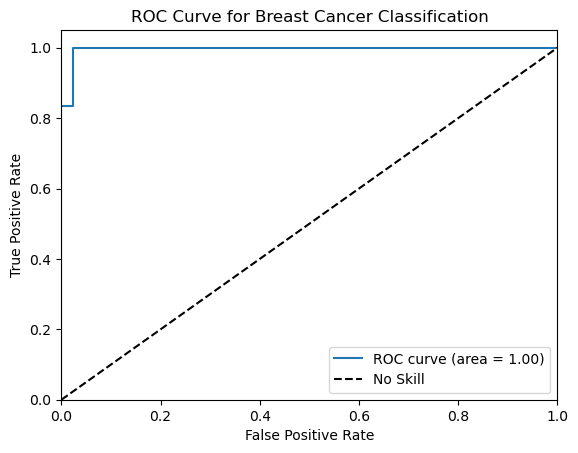

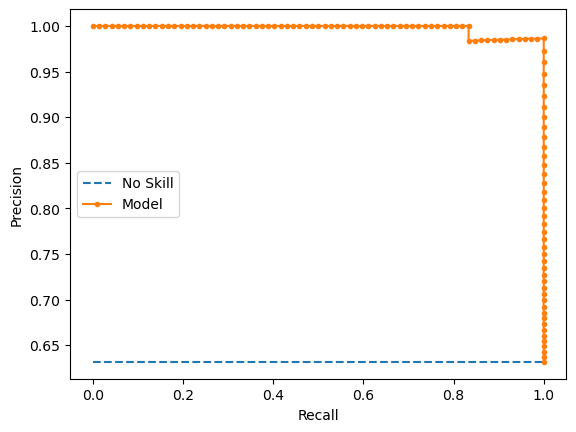

In [60]:
z = model_evaluation(X_test, y_test, lgbm_model,config)